# [NTDS'18] milestone 2: network models
[ntds'18]: https://github.com/mdeff/ntds_2018

[Hermina Petric Maretic](https://people.epfl.ch/hermina.petricmaretic), [EPFL LTS4](https://lts4.epfl.ch)

## Students

* Team: `<your team number>`
* Students: `<the name of all students in the team>`
* Dataset: `<the dataset you used to complete the milestone>`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* In the first part, you cannot import any other library than we imported. In the second part, you are allowed to import any library you want.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The purpose of this milestone is to explore various random network models, analyse their properties and compare them to your network. In the first part of the milestone you will implement two random graph models and try to fit them to your network. In this part you are not allowed to use any additional package. In the second part of the milestone you will choose a third random graph model that you think shares some properties with your network. You will be allowed to use additional packages to construct this network, but you must explain your network choice. Finally, make your code as clean as possible, and keep your textual answers short.

## Part 0

Import the adjacency matrix of your graph that you constructed in milestone 1, as well as the number of nodes and edges of your network.

In [1]:
import numpy as np

# We have several binary matrices created using different thresholds
filenames = ["adjacency_0.1", "adjacency_0.3", "adjacency_0.5", "adjacency_0.7", "adjacency_0.9"]

adjacencies_binary =  [np.load(file+".npy") for file in filenames]
n_nodes =  np.asarray([a.shape[0] for a in adjacencies_binary])
n_edges =  np.asarray([np.sum(a)/2 for a in adjacencies_binary])
thresholds = np.linspace(0.1, 0.9, 5)

## Part 1

**For the computation of this part of the milestone you are only allowed to use the packages that have been imported in the cell below.**

In [2]:
%matplotlib inline

import random

import pandas as pd
import matplotlib.pyplot as plt
import scipy

### Question 1

Create a function that constructs an Erdős–Rényi graph.

In [3]:
def erdos_renyi(n, p, seed=None):
    """Create an instance from the Erdos-Renyi graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    p: float
        Edge probability. A number between 0 and 1.
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    
    np.random.seed(seed)
    G = np.zeros((n,n))
    
    for i in range(n):
        for j in range(i,n):
            if i != j:
                r = random.random()
                if r <= p:
                    # Probability p that nodes are connected
                    G[i,j] = 1
                else:
                    continue
            else:
                # Nodes are not connected with themselves, leave the zeros
                continue
    adjacency = G + np.transpose(G)
    
    return adjacency

Text(0.5,1.05,'Erdos-Renyi (5, 0.6)')

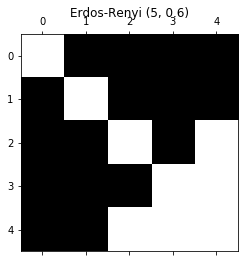

In [4]:
er = erdos_renyi(5, 0.6, 9765)
plt.spy(er)
plt.title('Erdos-Renyi (5, 0.6)')

Text(0.5,1.05,'Erdos-Renyi (10, 0.4)')

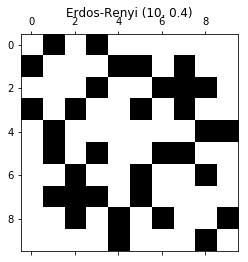

In [5]:
er = erdos_renyi(10, 0.4, 7648)
plt.spy(er)
plt.title('Erdos-Renyi (10, 0.4)')

### Question 2

Use the function to create a random Erdos-Renyi graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

In [6]:
# Take probability based on maximum possible number of edges and observed edges
p_link = n_edges/(n_nodes*(n_nodes-1)/2)
er_CN = [erdos_renyi(n, p) for n,p in zip(n_nodes,p_link)]
L_er = [(np.count_nonzero(er))/2 for er in er_CN]
n_nodes_er = [er.shape[0] for er in er_CN]
L = n_edges

for i in range(len(er_CN)):
    print("The number of links in the Erdos-Renyi graph with p = {0:.3f} is {1:.0f}".format(p_link[i], L_er[i]))
    print("The number of links in our graph with threshold {0:.1f} is {1:.0f}\n".format(thresholds[i], L[i]))

The number of links in the Erdos-Renyi graph with p = 0.806 is 16052
The number of links in our graph with threshold 0.1 is 16030

The number of links in the Erdos-Renyi graph with p = 0.634 is 12562
The number of links in our graph with threshold 0.3 is 12618

The number of links in the Erdos-Renyi graph with p = 0.376 is 7454
The number of links in our graph with threshold 0.5 is 7485

The number of links in the Erdos-Renyi graph with p = 0.236 is 4812
The number of links in our graph with threshold 0.7 is 4697

The number of links in the Erdos-Renyi graph with p = 0.179 is 3534
The number of links in our graph with threshold 0.9 is 3568



**Your answer here.**

### Question 3

Create a function that constructs a Barabási-Albert graph.

In [7]:
def barabasi_albert(n, m, m0, seed=None):
    """Create an instance from the Barabasi-Albert graph model.
    
    Parameters
    ----------
    n: int
        Size of the graph.
    m: int
        Number of edges to attach from a new node to existing nodes.
    m0: int
        Number of initial nodes
    seed: int (optional)
        Seed for the random number generator. To get reproducible results.
    
    Returns
    -------
    adjacency
        The adjacency matrix of a graph.
    """
    
    if m > m0:
        return print("The inital number of nodes is too small")
    
    np.random.seed(seed)
    
    # initalizing the graph
    G = np.zeros((n,n))
    nodes = np.arange(m0)
    

    # connecting the initial m0 nodes together
    for i in range(m0):
        G[i,i+1] = 1
    
    for j in range(m0,n):
    
        # count degrees of existing nodes
        k_i = np.sum(G[nodes, :],axis = 1)
        
        # Nodes to which no edge exists yet
        available_nodes = nodes
    
        # add m links to new node
        rand_nb = np.random.rand(m)  

        for i in range(m):
            # compute probability of connection with each available node
            p = k_i[available_nodes]/np.sum(k_i[available_nodes])
            
            # compute cumulated probability array which can be used to classifiy a generated random number
            p_cum = np.cumsum(p)
            
            target_index = min(np.argwhere(p_cum >= rand_nb[i]))
            target_node = available_nodes[target_index]
            available_nodes = np.delete(available_nodes, target_index)
    
            # We connect the selected target node
            G[j,target_node] = 1
        
        # Finally, we add the new node to our existing node list
        nodes = np.append(nodes, j)
    
    adjacency = G + np.transpose(G)
    
    
    return adjacency


Text(0.5,1.05,'Barabasi-Albert (5, 1)')

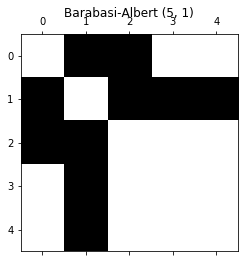

In [8]:
ba = barabasi_albert(5, 1, 2, 9087)
plt.spy(ba)
plt.title('Barabasi-Albert (5, 1)')

Text(0.5,1.05,'Barabasi-Albert (10, 2)')

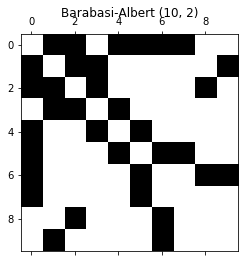

In [9]:
ba = barabasi_albert(10, 2, 2, 8708)
plt.spy(ba)
plt.title('Barabasi-Albert (10, 2)')

### Question 4

Use the function to create a random Barabási-Albert graph. Choose the parameters such that number of nodes is the same as in your graph, and the number of edges similar. You don't need to set the random seed. Comment on your choice of parameters.

**The number of edges $w$ in a random Barabási-Albert graph with $n$ nodes and is given by
\begin{equation}
w = m_0 + (n-m_0)m 
\end{equation}
Thus, if a given number of edges $w^*$ should be contained in the graph (similar to the number of edges in our network), we need to find the integer solution to the above equations with the constraint $m \leq m_0$.
For the networks that were created with the thresholds 0.1 and 0.3, the number of edges is $>10000$ and it is impossible to find a corresponding $m$ and $m_0$ that result in a similar number of edges.**

In [10]:
# These m0 and m correspond to a final number of edges similar to the real network with thresholds 0.5, 0.7 and 0.9
ba_param = [(48,48),(50,31),(32,21)]

ba_CN = [barabasi_albert(200, param[1], param[0]) for param in ba_param]
n_nodes_ba_CN = [ba.shape[0] for ba in ba_CN]
n_edges_ba_CN = [np.sum(ba)/2 for ba in ba_CN]

#plt.spy(ba_CN)
#plt.title('Barabasi-Albert Conseil National (10, 2)')
for i in range(len(ba_CN)):
    print ("Simulation of a BA model with {0} inital nodes, {1} links per new node"
           .format(ba_param[i][0], ba_param[i][1]))
    print ("The number of nodes with this BA model: %d " % n_nodes_ba_CN[i])
    print ("The number of edges with this BA model: %d\n" % n_edges_ba_CN[i])


Simulation of a BA model with 48 inital nodes, 48 links per new node
The number of nodes with this BA model: 200 
The number of edges with this BA model: 7344

Simulation of a BA model with 50 inital nodes, 31 links per new node
The number of nodes with this BA model: 200 
The number of edges with this BA model: 4700

Simulation of a BA model with 32 inital nodes, 21 links per new node
The number of nodes with this BA model: 200 
The number of edges with this BA model: 3560



### Question 5

Compare the number of edges in all three networks (your real network, the Erdős–Rényi network, and the Barabási-Albert netowk).

In [11]:
for i in range(len(thresholds)):
    print ("\nReal network created with threshold {0:.1f}: Nodes: {1} Edges: {2:.0f}"
           .format(thresholds[i],n_nodes[i], n_edges[i]))
    print ("Erdös-Rényi network                      Nodes: {0} Edges: {1:.0f}"
           .format(n_nodes_er[i], L_er[i]))
    
    # For thresholds 0.1 and 0.3, no equivalent BA network can be created
    if i > 1:
        print ("Barabási-Albert network                  Nodes: {0} Edges: {1:.0f}"
               .format(n_nodes_ba_CN[i-2], n_edges_ba_CN[i-2])) 



Real network created with threshold 0.1: Nodes: 200 Edges: 16030
Erdös-Rényi network                      Nodes: 200 Edges: 16052

Real network created with threshold 0.3: Nodes: 200 Edges: 12618
Erdös-Rényi network                      Nodes: 200 Edges: 12562

Real network created with threshold 0.5: Nodes: 200 Edges: 7485
Erdös-Rényi network                      Nodes: 200 Edges: 7454
Barabási-Albert network                  Nodes: 200 Edges: 7344

Real network created with threshold 0.7: Nodes: 200 Edges: 4697
Erdös-Rényi network                      Nodes: 200 Edges: 4812
Barabási-Albert network                  Nodes: 200 Edges: 4700

Real network created with threshold 0.9: Nodes: 200 Edges: 3568
Erdös-Rényi network                      Nodes: 200 Edges: 3534
Barabási-Albert network                  Nodes: 200 Edges: 3560


### Question 6

Implement a function that computes the [Kullback–Leibler (KL) divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between two probability distributions.
We'll use it to compare the degree distributions of networks.

In [12]:
def kl_divergence(p, q):
    """Compute the KL divergence between probability distributions of degrees of two networks.
    
    Parameters
    ----------
    p: np.array
        Probability distribution of degrees of the 1st graph.
    q: np.array
        Probability distribution of degrees of the 2nd graph.
    
    Returns
    -------
    kl
        The KL divergence between the two distributions.
    """
    
    kl=np.dot(p,np.log(p/q))
    
    return kl

In [13]:
p_test = np.array([0.2, 0.2, 0.2, 0.4])
q_test = np.array([0.3, 0.3, 0.1, 0.3])
kl_divergence(p_test, q_test)

0.09151622184943572

### Question 7

Compare the degree distribution of your network to each of the two synthetic ones, in terms of KL divergence. **Hint:** Make sure you normalise your degree distributions to make them valid probability distributions.

In [14]:
def get_degree_distibution(adjacency, bins=None, laplace_smoothing=True, set_minmax=None):
    """"This function returns the degree distribution for a graph with adjacency matrix adjacency.
    In order to compute meaningful KL divergences, the degree axis is divided into intervals
    and an average degree per intervall is computed. Furthermore, Laplace smoothing can be enabled in order to avoid 
    zero frequencies for some intervals which is necessary for the computation of the KL divergence.
    
    Returns vector of interval midpoints (degrees), probability for node to have a degree inside a certain interval,
    average and extremas of the degree distirbution"""
    
    """ bins: number of intervalls between k_min and k_max
        set_minmax: The minimum and maximum of the k axis can optionally be chosen. Along with the bins argument,
        the sampling points can implicitly be chosen
        laplace_smoothing: enables additive laplace smoothing. One occurence of a degree inside a given interval is 
        added to the counts actually observed in the adjacency matrix. This avoids having zero probabilities in 
        certain intervals of k, thus avoiding problems when computing KL-Divergence. """
        
    k_i = np.sum(adjacency, axis=1)/2
    k_i.sort()
    k_freq, counts = np.unique(k_i, return_counts=True)
    
    if bins == None:
        return k_freq, counts/np.sum(counts), [np.mean(k_i), (min(k_i), max(k_i))]
    
    # Create sample intervalls
    if set_minmax == None:
        dk, h = np.linspace(min(k_freq), max(k_freq), bins+1, retstep=True)
    else:
        dk, h = np.linspace(set_minmax[0], set_minmax[1], bins+1, retstep=True)
    
    # Midpoints of the sampling intervals
    k_s = dk[1:] - h/2
    counts_s = []
    prev_idx = 0
    
    # Laplace smoothing to avoid zero frequencies
    if laplace_smoothing:
        alpha = 1;
        d = len(dk[1:])
    else:
        alpha = 0;
        d = 0;
        
    # Sample degree distribution
    for k in dk[1:]:
        idx_smaller = np.argwhere(k_freq <= k)
        if idx_smaller.size == 0:
            counts_s.append(alpha)
            continue
        else:
            idx = max(idx_smaller)+1
            idx = np.asscalar(idx)
            counts_s.append(np.sum(counts[prev_idx:idx])+alpha)
            prev_idx = idx
    # Normalize distribution
    counts_s = np.array(counts_s)/(sum(counts_s)+d*alpha)
    
    # Return mean, max and min of degree distribution
    stats = [np.mean(k_i), (min(k_i), max(k_i))]
    return k_s, counts_s, stats 

In [15]:
# Computation of normalized degree distributions
intervals = 66
# Degrees from 0 to 100 and apply smoothing to avoid non-zero frequencies 
k_minmax = (0,100)
smooth = True

# Degree distributions for real network, ER and BA corresponding to thresholds 0.3, 0.5, 0.7
deg_dist = [get_degree_distibution(adj_bin, bins=intervals,
                                laplace_smoothing=smooth, set_minmax=k_minmax) for adj_bin in adjacencies_binary[1:4]]
deg_dist_er = [get_degree_distibution(er, bins=intervals, 
                                laplace_smoothing=smooth, set_minmax=k_minmax) for er in er_CN[1:4]]
deg_dist_ba = [get_degree_distibution(ba, bins=intervals,
                                laplace_smoothing=smooth, set_minmax=k_minmax) for ba in ba_CN]

In [16]:
# Prepare iterables
k = []; p = []; k_er = []; p_er = []; k_ba = []; p_ba = []
for real, er, ba in zip(deg_dist, deg_dist_er, deg_dist_ba):
    k.append(real[0])
    p.append(real[1])
    k_er.append(er[0])
    p_er.append(er[1])
    k_ba.append(ba[0])
    p_ba.append(ba[1])


In [17]:
# Calculate Kullback-Leibler divergences
kl_er = [kl_divergence(weights, weights_er) for weights, weights_er in zip(p, p_er)]
kl_ba = [kl_divergence(weights,weights_ba) for weights, weights_ba in zip(p[1:3], p_ba[0:2])]

for i in range(3):
    print("\nKL-Divergence from the real network with threshold {0:.1f} to the ER network: {1:.3f}"
          .format(thresholds[i+1],kl_er[i]))
    if i > 0:
        print("KL-Divergence from the real network with threshold {0:.1f} to the BA network: {1:.3f}"
          .format(thresholds[i+1],kl_ba[i-1]))


KL-Divergence from the real network with threshold 0.3 to the ER network: 0.652

KL-Divergence from the real network with threshold 0.5 to the ER network: 0.136
KL-Divergence from the real network with threshold 0.5 to the BA network: 0.532

KL-Divergence from the real network with threshold 0.7 to the ER network: 0.910
KL-Divergence from the real network with threshold 0.7 to the BA network: 1.011


### Question 8

Plot the degree distribution historgrams for all three networks. Are they consistent with the KL divergence results? Explain.

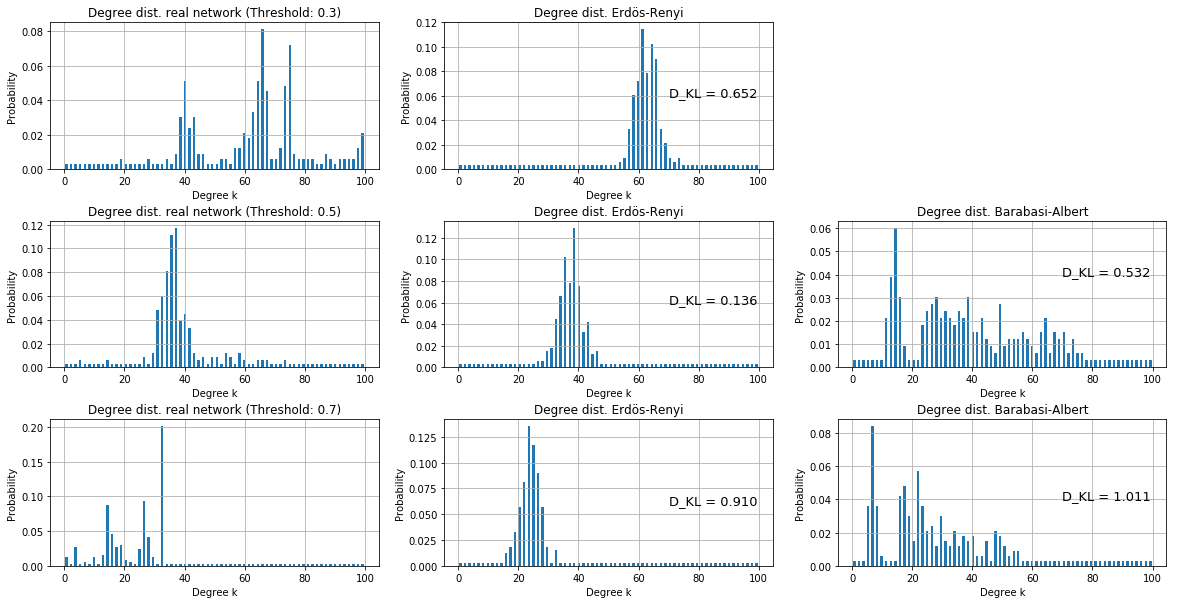

In [18]:
# Degree distributions of real network (thres. 0.3, 0.5, 0.7) and the equivalent ER and BA in the same row
plt.figure(figsize=(20, 10))
for i in range(3):
    plt.subplot(3,3,1+3*i)
    plt.bar(k[i], p[i])
    plt.grid(True)
    plt.xlabel("Degree k")
    plt.ylabel("Probability")
    plt.title("Degree dist. real network (Threshold: {0:.1f})".format(thresholds[i+1]))
    plt.subplot(3,3,2+3*i)
    plt.bar(k_er[i], p_er[i])
    plt.grid(True)
    plt.xlabel("Degree k")
    plt.ylabel("Probability")
    plt.title("Degree dist. Erdös-Renyi")
    plt.text(70,0.06,"D_KL = {0:.3f}".format(kl_er[i]), fontsize=13)
    if i > 0:
        plt.subplot(3,3,3+3*i)
        plt.bar(k_ba[i-1], p_ba[i-1])
        plt.grid(True)
        plt.xlabel("Degree k")
        plt.ylabel("Probability")
        plt.title("Degree dist. Barabasi-Albert")
        plt.text(70,0.04,"D_KL = {0:.3f}".format(kl_ba[i-1]), fontsize=13)
plt.subplots_adjust(hspace=0.35, wspace=0.2)

### Question 9

Imagine you got equal degree distributions. Would that guarantee you got the same graph? Explain.

**Your answer here.**

## Part 2

**You are allowed to use any additional library here (e.g., NetworkX, PyGSP, etc.).** Be careful not to include something here and use it in part 1!

### Question 10

Choose a random network model that fits you network well. Explain your choice. 

**Hint:** Check lecture notes for different network models and their properties. Your choice should be made based on at least one property you'd expect to be similar.

**Your answer here.**

### Question 11

Explain (in short) how the chosen model works.

**Your answer here.**

### Question 12

Create a random graph from that model, such that the number of nodes is the same as in your graph.

In [19]:
def preferential_attachment_graph(n, n_links, seed=None):
    """Based on the Barabasi-Albert graph, but without network growth. At each instance t, a link is added to a node
    out of n nodes in the network with preferential attachment"""
    
    if n_links > n*(n-1)/2:
        return print("The number of edges is larger than the maximum number of edges possible")
    
    np.random.seed(seed)
    G = np.zeros((n,n))
    nodes = np.arange(n)
    
    # Initial attachment probability (unconnected nodes have Pi(1) => equivalent to every node having one link)
    k_i = np.ones(n)
    fully_connected_nodes = []
    
    for t in range(n_links):
        rand_number = np.random.random(2)
        # Nodes that are already fully connected can be connected more
        k1 = np.delete(k_i, fully_connected_nodes)
        # Cum. probability to connect to any of the non-fully connected nodes
        p1 = np.cumsum(k1)/np.sum(k1)
        nodes_1 = np.delete(nodes, fully_connected_nodes)
        
        # Choose first node and remove node and neighbours temporarily from list
        node_1 = np.asscalar(nodes_1[min(np.argwhere(p1 >= rand_number[0]))])
        node_1_neighbours = np.nonzero(G[node_1,:])
        
        # Attachment probability for the remaining available nodes (Can't connect to itself and already connected nodes)
        excluded_nodes = np.append(node_1, node_1_neighbours)
        k2 = np.delete(k_i, excluded_nodes)
        p2 = np.cumsum(k2)/np.sum(k2)
        nodes_2 = np.delete(nodes, excluded_nodes)

        # Choose second node
        node_2 = np.asscalar(nodes_2[min(np.argwhere(p2 >= rand_number[1]))])
        # Connect them
        G[node_1, node_2] = 1
        G[node_2, node_1] = 1
        
        # Check if nodes are now fully connected
        if np.count_nonzero(G[node_1,:])>= n-1:
            fully_connected_nodes.append(node_1)
        if np.count_nonzero(G[node_2,:]) >= n-1:
            fully_connected_nodes.append(node_2)
            
        # Update degrees
        k_i[node_1] += 1
        k_i[node_2] += 1
    
    return G


graph = preferential_attachment_graph(n_nodes[2], int(n_edges[2]), seed=2)
intervals = None
k, weights, stats = get_degree_distibution(graph, bins=intervals) 

Text(0.5,1,'Degree distribution (k-intervalls: None)')

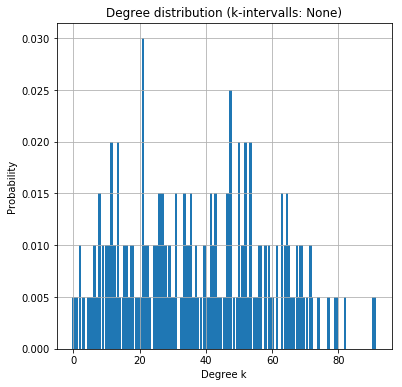

In [20]:
plt.figure(figsize=(6, 6))
plt.bar(k, weights)
plt.grid(True)
plt.xlabel("Degree k")
plt.ylabel("Probability")
plt.title("Degree distribution (k-intervalls: {0})".format(intervals))

### Question 13

Check the properties you expected to be similar, and compare to your network.

In [21]:
# Your code here.

Are the results what you expected? Explain.

**Your answer here.**